In [1]:
import sys
sys.path.insert(0,'./yolov3/code/')
#sys.path.insert(0,'./yolov3/yolov3_resnet18/')
import numpy as np
from src.config import ConfigYOLOV3ResNet18

def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """Apply NMS to bboxes."""
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        if len(keep) >= max_boxes:
            break

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thres)[0]

        order = order[inds + 1]
    return keep
def tobox(boxes, box_scores):
    """Calculate precision and recall of predicted bboxes."""
    config = ConfigYOLOV3ResNet18()
    num_classes = config.num_classes
    mask = box_scores >= config.obj_threshold
    boxes_ = []
    scores_ = []
    classes_ = []
    max_boxes = config.nms_max_num
    for c in range(num_classes):
        class_boxes = np.reshape(boxes, [-1, 4])[np.reshape(mask[:, c], [-1])]
        class_box_scores = np.reshape(box_scores[:, c], [-1])[np.reshape(mask[:, c], [-1])]
        nms_index = apply_nms(class_boxes, class_box_scores, config.nms_threshold, max_boxes)
        #nms_index = apply_nms(class_boxes, class_box_scores, 0.5, max_boxes)
        class_boxes = class_boxes[nms_index]
        class_box_scores = class_box_scores[nms_index]
        classes = np.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)

    boxes = np.concatenate(boxes_, axis=0)
    classes = np.concatenate(classes_, axis=0)
    scores = np.concatenate(scores_, axis=0)

    return boxes, classes, scores

In [2]:

"""Evaluation for yolov3-resnet18"""
import os
import argparse
import time
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
from PIL import Image
import PIL

from mindspore import context, Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from src.yolov3 import yolov3_resnet18, YoloWithEval
from src.dataset import create_yolo_dataset, data_to_mindrecord_byte_image
from src.config import ConfigYOLOV3ResNet18
from src.utils import metrics


def yolo_eval(dataset_path, ckpt_path, out_path):
    """Yolov3 evaluation."""
    
    ds = create_yolo_dataset(dataset_path, batch_size=1, is_training=False)
    config = ConfigYOLOV3ResNet18()
    net = yolov3_resnet18(config)
    eval_net = YoloWithEval(net, config)
    print("Load Checkpoint!")
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)

    eval_net.set_train(False)
    i = 1.
    total = ds.get_dataset_size()
    print(total)
    start = time.time()
    pred_data = []
    print("\n========================================\n")
    print("total images num: ", total)
    print("Processing, please wait a moment.")
    
    num_class={0:'person', 1: 'face', 2:'mask'}
    for data in ds.create_dict_iterator(output_numpy=True):
        #print(data)
        img_np = data['image']
        print(img_np.shape)
        image_shape = data['image_shape']
        #image_old = data['image_old']
        print(image_shape)
        annotation = data['annotation']
        image_file = data['file']
        image_file= image_file.tostring().decode('ascii')
        
        eval_net.set_train(False)
        output = eval_net(Tensor(img_np), Tensor(image_shape))
        for batch_idx in range(img_np.shape[0]):
            boxes = output[0].asnumpy()[batch_idx]
            box_scores = output[1].asnumpy()[batch_idx]
            image = img_np[batch_idx,...]
            boxes, classes, scores =tobox(boxes, box_scores)
            print(classes)
            print(scores)
            fig = plt.figure()   #相当于创建画板
            ax = fig.add_subplot(1,1,1)   #创建子图，相当于在画板中添加一个画纸，当然可创建多个画纸，具体由其中参数而定
            image_path = os.path.join(cfg.image_dir, image_file)
            f = Image.open(image_path) 
            img_np = np.asarray(f ,dtype=np.float32)  #H，W，C格式 
            ax.imshow(img_np.astype(np.uint8))  #当前画纸中画一个图片
    
            for box_index in range(boxes.shape[0]):
                ymin=boxes[box_index][0]
                xmin=boxes[box_index][1]
                ymax=boxes[box_index][2]
                xmax=boxes[box_index][3]
                print(xmin,ymin,xmax,ymax)
                #添加方框，(xmin,ymin)表示左顶点坐标，(xmax-xmin),(ymax-ymin)表示方框长宽
                ax.add_patch(plt.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,edgecolor='red', linewidth=2))
                #给方框加标注，xmin,ymin表示x,y坐标，其它相当于画笔属性
                ax.text(xmin,ymin,s = str(num_class[classes[box_index]])+str(scores[box_index]),style='italic',bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 0})
    
            plt.show()

INFO:root:Using MoXing-v1.17.3-43fbf97f
INFO:root:Using OBS-Python-SDK-3.20.7
INFO:root:Listing OBS: 1000
INFO:root:pid: None.	1000/1008
[WARNING] ME(13248:281473379326336,MainProcess):2020-11-24-10:43:44.637.328 [mindspore/dataset/engine/datasets.py:3064] WARN: global shuffle is not used.


{'data_url': 's3://yyq-2/DATA/code/yolov3/mask_detection_500/mask_detection_500', 'ckpt_url': 's3://yyq-2/DATA/code/yolov3/yolov3_out/60/ckpt_0', 'train_url': 's3:/yyq-2/DATA/yolov3/yolov3_eval_out'}
Create Mindrecord.
Create Mindrecord Done, at ./mindrecord_dir
['yolo_test.mindrecord', 'yolo_test.mindrecord.db']
Start Eval!
Load Checkpoint!
8


total images num:  8
Processing, please wait a moment.
(1, 3, 352, 640)
[1080. 1920.]
[0 0 0 0 0 1 1]
[0.8116566  0.70857424 0.67135185 0.57870406 0.47335678 0.676999
 0.39446598]
482.65222 609.628 707.4597 734.10065
316.5449 498.4737 468.00876 637.595
909.46423 326.4718 1040.0024 483.868
1093.5005 195.755 1139.6392 259.82785
315.45667 750.9953 480.8555 882.3885
542.8285 625.66846 641.7321 699.56995
347.509 519.02637 441.16946 609.3047


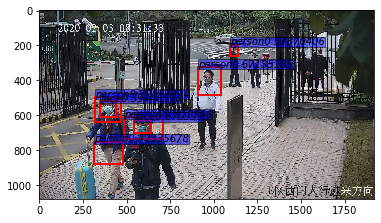

(1, 3, 352, 640)
[1080. 1920.]
[0 0 0 0 0 1]
[0.68615    0.55131    0.4389386  0.38900527 0.30652857 0.5582273 ]
230.71068 775.7789 593.5068 1053.3636
782.595 330.31546 893.7371 508.9189
358.8921 427.16565 513.7775 534.78925
699.25824 345.20828 936.11346 560.6014
790.19037 395.35583 878.9765 609.14233
384.01086 435.46863 483.1389 513.99963


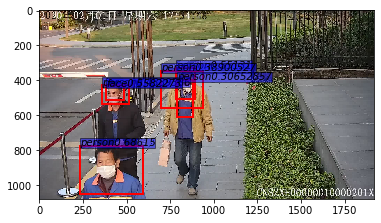

(1, 3, 352, 640)
[1080. 1920.]
[0 0 0 0 1 1 1]
[0.9437102  0.85002905 0.8013996  0.5418757  0.61524725 0.5412406
 0.3317431 ]
370.08957 165.7947 544.7216 288.81723
650.7249 170.703 828.0312 299.63736
969.54663 205.98135 1181.8192 340.26688
1778.2292 184.17467 1925.7697 339.0078
408.40918 174.57472 496.9094 257.79382
1024.2673 228.35631 1110.6066 300.78308
689.96204 185.77745 766.89465 258.09158


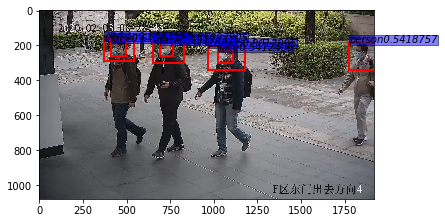

(1, 3, 352, 640)
[1080. 1920.]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.8984945  0.78246236 0.60854673 0.60281706 0.48090902 0.4757877
 0.46231946 0.4449384  0.43686318 0.38744903 0.34499082 0.3413009
 0.32626963]
767.1968 644.3692 922.8974 771.9416
1019.28064 612.59503 1170.8925 751.37286
676.3592 432.7883 774.51666 575.8891
698.4979 306.54385 750.58545 355.55045
1023.56964 751.37213 1209.1356 886.0701
914.73566 462.95688 1025.8481 565.4431
498.85638 302.7582 547.9088 351.69302
744.0455 312.92593 836.8212 414.14398
626.9801 261.16138 674.12067 302.1079
655.9992 308.38138 729.14044 420.39224
712.02344 550.43066 852.17303 676.26306
635.092 211.74242 666.23126 250.3857
771.0348 327.66885 827.67554 382.31293


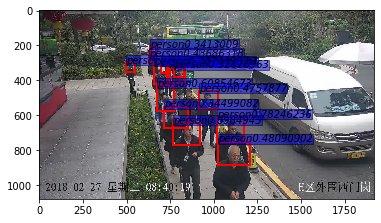

(1, 3, 352, 640)
[ 720. 1280.]
[0 0 1 2]
[0.72629315 0.44231877 0.87351453 0.92075413]
377.64514 168.13399 1098.1765 719.9583
561.60004 243.46518 1002.93915 601.6969
594.95337 203.79448 897.3198 541.47424
585.39844 308.3843 883.62354 523.02747


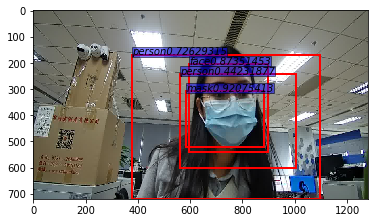

(1, 3, 352, 640)
[ 720. 1280.]
[0 1]
[0.69060415 0.61939365]
443.042 409.7184 773.8168 684.6526
527.48346 386.84866 680.13696 600.6681


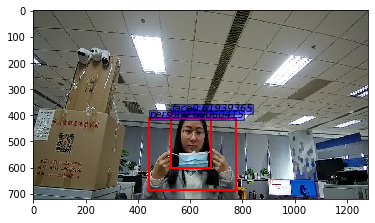

(1, 3, 352, 640)
[1080. 1920.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0.9630515  0.90109825 0.825129   0.6832232  0.5530061  0.46745765
 0.4646724  0.4540123  0.4364435  0.357293   0.35616356 0.3532506
 0.33031467 0.3209361  0.31732064 0.3467312 ]
818.7266 697.11804 967.988 817.4449
1028.8578 881.28827 1202.618 1008.79834
754.5953 529.9806 855.2213 631.2812
746.7727 282.71457 800.1183 326.23813
918.57214 325.6081 1033.9066 415.23856
678.0253 262.44064 713.46606 300.1795
498.71143 299.9239 547.096 351.71045
615.63544 221.08055 638.26215 244.32513
652.358 285.21594 710.88947 322.6076
913.6301 357.27924 989.37 472.42325
977.29944 323.7296 1075.8773 401.51166
1022.8189 326.36588 1065.0032 383.7724
760.5933 199.79373 785.1852 219.02188
754.12 264.17993 791.162 308.95224
683.52325 243.40096 713.0846 280.18472
1075.1938 908.68994 1168.5146 978.1447


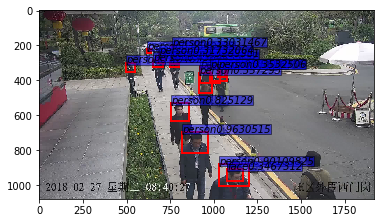

(1, 3, 352, 640)
[1080. 1920.]
[0 0 0 1 2]
[0.9634055  0.9174493  0.505475   0.3412669  0.33629176]
353.66022 236.6315 685.9309 496.88956
827.4838 331.4692 1118.8563 600.5137
1137.7704 546.54596 1431.0698 806.1061
439.8266 261.1625 574.661 440.53073
473.4643 308.20834 553.481 411.448


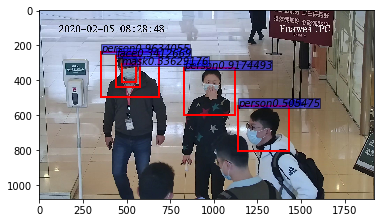

In [3]:
cfg = edict({
    "device_id": 0,
    #"h5_file": './result.h5',
    "mode": "source",    # {mindrecord , source}
    "mindrecord_dir": "./mindrecord_dir"
})
args_opt = edict({
    "data_url": 's3://{user_obs}/mask_detection_500/mask_detection_500',
    "ckpt_url": 's3://{user_obs}/ckpt_0',   # ckpt path
    "train_url": 's3:/user_obs}/yolov3_eval_out'   #out path
    
    #"data_url": 's3://yyq-2/DATA/code/yolov3/mask_detection_500/mask_detection_500',
    #"ckpt_url": 's3://yyq-2/DATA/code/yolov3/yolov3_out/60/ckpt_0',   #obs://yyq-2/DATA/code/yolov3/yolov3_out/60
    #"train_url": 's3:/yyq-2/DATA/yolov3/yolov3_eval_out'
}) 

import moxing as mox
ckpt_path = './ckpt/'
mox.file.copy_parallel(src_url=args_opt.ckpt_url, dst_url=ckpt_path)
cfg.ckpt_path = os.path.join(ckpt_path, "yolov3-90_15.ckpt") 

data_path = './data/' 
mox.file.copy_parallel(src_url=args_opt.data_url, dst_url=data_path)
if cfg.mode=="mindspore":
    #cfg.mindrecord_dir = os.path.join(data_path,'eval')
    cfg.mindrecord_dir = os.path.join(data_path)
else:
    cfg.image_dir = os.path.join(data_path, "test")   


context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=cfg.device_id)

# It will generate mindrecord file in args_opt.mindrecord_dir,
# and the file name is yolo.mindrecord0, 1, ... file_num.
if not os.path.isdir(cfg.mindrecord_dir):
    os.makedirs(cfg.mindrecord_dir)
prefix = "yolo_test.mindrecord"
mindrecord_file = os.path.join(cfg.mindrecord_dir, prefix)
print(args_opt)
if cfg.mode=="source":
    print("Create Mindrecord.")
    data_to_mindrecord_byte_image(cfg.image_dir,
                         cfg.mindrecord_dir,
                         prefix,
                         1)
    print("Create Mindrecord Done, at {}".format(cfg.mindrecord_dir))
    all_files = os.listdir(cfg.mindrecord_dir)
    print(all_files)
    #mox.file.copy_parallel(src_url=args_opt.mindrecord_dir, dst_url=os.path.join(args_opt.data_url,'train')
elif args_opt.mode=="mindspore":
    pass
else:
    raise ValueError('image_dir {} does not exist'.format(cfg.image_dir))

print("Start Eval!")
yolo_eval(mindrecord_file, cfg.ckpt_path, args_opt.train_url)